# Inheritance

This notebook demonstrates the use of inheritance to extend Python's `Counter` class to implement Multisets, PMFs, and suites of Bayesian hypotheses.

In [1]:
from __future__ import print_function, division

from collections import Counter
import numpy as np

### Counter

A `Counter` is a map from values to their frequencies.  If you initialize a `Counter` with a string, you get a map from each letter to the number of times it appears.  If two words are anagrams, they yield equal Counters, so you can use Counters to test anagrams in linear time.

In [2]:
def is_anagram(word1, word2):
    """Checks whether the words are anagrams.

    word1: string
    word2: string

    returns: boolean
    """
    return Counter(word1) == Counter(word2)

In [3]:
is_anagram('tachymetric', 'mccarthyite')

True

In [4]:
is_anagram('banana', 'peach')

False

**Exercise:** The `Counter` class inherits from `dict` so all methods and functions that work with a dictionary will also work with a `Counter`.

Read [the documentation of Counter](https://docs.python.org/3/library/collections.html#collections.Counter), then use a `Counter` to find the three most common letters in the word "pneumonoultramicroscopicsilicovolcanoconiosis".

In [5]:
Counter('pneumonoultramicroscopicsilicovolcanoconiosis').most_common(3)

[('o', 9), ('i', 6), ('c', 6)]

### Multisets

A `Counter` is a natural representation of a multiset, which is a set where the elements can appear more than once.  
The following example creates a new class called `Multiset` that has all the methods of `Counter` plus an additional method called `is_subset`.

In [6]:
class Multiset(Counter):
    """A multiset is a set where elements can appear more than once."""

    def is_subset(self, other):
        """Checks whether self is a subset of other.

        other: Multiset

        returns: boolean
        """
        for char, count in self.items():
            if other[char] < count:
                return False
        return True
    
    # map the <= operator to is_subset
    __le__ = is_subset

You could use `is_subset` in a game like Scrabble to see if a given set of tiles can be used to spell a given word.

Because Multiset defines a method named `__le__`, we can use the `<=` operator on `Multiset` objects.

In [7]:
def can_spell(word, tiles):
    """Checks whether a set of tiles can spell a word.

    word: string
    tiles: string

    returns: boolean
    """
    return Multiset(word) <= Multiset(tiles)

In [8]:
can_spell('SYZYGY', 'AGSYYYZ')

True

In [9]:
can_spell('omelette', 'breaking a few eggs')

False

**Exercise:** Write a version of `can_spell` that uses the `Counter` method `subtract` and then checks whether there are any negative values, which would indicate a shortage of tiles.

In [10]:
def can_spell2(word, tiles):
    """Checks whether a set of tiles can spell a word.

    word: string
    tiles: string

    returns: boolean
    """
    ms = Multiset(tiles)
    ms.subtract(Multiset(word))
    return all(value >= 0 for value in ms.values())

In [11]:
can_spell2('SYZYGY', 'AGSYYYZ')

True

In [12]:
can_spell2('omelette', 'breaking a few eggs')

False

### Probability Mass Functions

You can also extend `Counter` to represent a probability mass function (PMF).  A PMF is a map from possible outcomes to their probabilities.  The probabilities in a PMF are "normalized" if they add up to 1 (and they are all non-negative).

The following `PMF` class inherits from `Counter` and adds the following methods:

* `normalize` computes the total of the frequencies and divides through, yielding probabilities that add to 1.

* `__add__` enumerates all pairs of outcomes and returns a new Pmf that represents the distribution of the sum.

* `render` returns the outcomes and probabilities in a form ready for plotting.

In [13]:
class Pmf(Counter):
    """A Counter with probabilities."""

    def normalize(self):
        """Normalizes the PMF so the probabilities add to 1."""
        total = sum(self.values())
        for key in self:
            self[key] /= total

    def __add__(self, other):
        """Adds two distributions.

        The result is the distribution of sums of outcomes from the
        two distributions.

        other: Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for key1, prob1 in self.items():
            for key2, prob2 in other.items():
                pmf[key1 + key2] += prob1 * prob2
        return pmf

    def render(self):
        """Returns outcomes and their probabilities, suitable for plotting."""
        return zip(*sorted(self.items()))

As an example, we can make a Pmf object that represents a 6-sided die.

In [14]:
d6 = Pmf([1,2,3,4,5,6])
d6.normalize()
d6.name = 'one die'
print(d6)

Pmf({1: 0.16666666666666666, 2: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.16666666666666666, 6: 0.16666666666666666})


Using the add operator, we can compute the distribution for the sum of two dice.

In [15]:
d6_twice = d6 + d6
d6_twice.name = 'two dice'

for key, prob in d6_twice.items():
    print(key, prob)

2 0.027777777777777776
3 0.05555555555555555
4 0.08333333333333333
5 0.1111111111111111
6 0.1388888888888889
7 0.16666666666666669
8 0.1388888888888889
9 0.1111111111111111
10 0.08333333333333333
11 0.05555555555555555
12 0.027777777777777776


Using `sum` or `np.sum`, we can compute the distribution for the sum of three dice.

In [16]:
# if we use the built-in sum we have to provide a Pmf additive identity
pmf_ident = Pmf([0])
d6_thrice = sum([d6]*3, pmf_ident)

In [17]:
# with np.sum, we don't need an identity
d6_thrice = np.sum([d6]*3)
d6_thrice.name = 'three dice'

And then plot the results (using Pmf.render)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

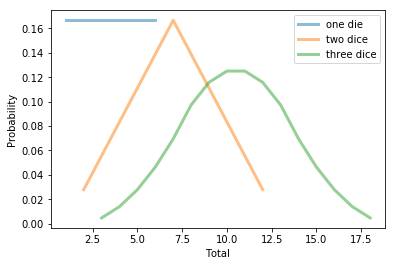

In [19]:
for die in [d6, d6_twice, d6_thrice]:
    xs, ys = die.render()
    plt.plot(xs, ys, label=die.name, linewidth=3, alpha=0.5)
    
plt.xlabel('Total')
plt.ylabel('Probability')
plt.legend()
plt.show()

**Exercise:** Suppose you are fighting an orc who will die if he suffers 9 or more hit points of damage.  You attack successfully with [short sword](https://roll20.net/compendium/dnd5e/Shortsword#content) and [dagger](https://roll20.net/compendium/dnd5e/Dagger#content), so you can roll a d6 and a d4 for total damage.  What is the probability that you kill the orc?

In [20]:
d4 = Pmf([1,2,3,4])
d4.normalize()
hp = d6 + d4
hp

Pmf({2: 0.041666666666666664,
     3: 0.08333333333333333,
     4: 0.125,
     5: 0.16666666666666666,
     6: 0.16666666666666666,
     7: 0.16666666666666666,
     8: 0.125,
     9: 0.08333333333333333,
     10: 0.041666666666666664})

In [21]:
hp[9] + hp[10]

0.125

### Bayesian statistics

A `Suite` is a `Pmf` that represents a set of hypotheses and their probabilities; it provides `bayesian_update`, which updates the probability of the hypotheses based on new data.

`Suite` is an abstract parent class; child classes should provide a `likelihood` method that evaluates the likelihood of the data under a given hypothesis.  `update_bayesian` loops through the hypotheses, evaluates the likelihood of the data under each hypothesis, and updates the probabilities accordingly.  Then it re-normalizes the PMF.

In [22]:
class Suite(Pmf):
    """Map from hypothesis to probability."""

    def bayesian_update(self, data):
        """Performs a Bayesian update.
        
        Note: called bayesian_update to avoid overriding dict.update

        data: result of a die roll
        """
        for hypo in self:
            like = self.likelihood(data, hypo)
            self[hypo] *= like

        self.normalize()
        
    def print_probs(self):
        for hypo in sorted(self):
            print(hypo, self[hypo])

As an example, I'll use `Suite` to solve the "Dice Problem," from Chapter 3 of <i>Think Bayes</i>.

"Suppose I have a box of dice that contains a 4-sided die, a 6-sided die, an 8-sided die, a 12-sided die, and a 20-sided die. If you have ever played Dungeons & Dragons, you know what I am talking about.  Suppose I select a die from the box at random, roll it, and get a 6. What is the probability that I rolled each die?"


I'll start by defining `DiceSuite`, which inherits `bayesian_update` from Suite and provides `likelihood`.

`data` is the observed die roll, 6 in the example.

`hypo` is the hypothetical number of sides on the die.

If `data > hypo`, that means the outcome exceeds the number of sides on the die; that's impossible, so it has probability 0.

Otherwise, the probability of any outcome is `1/hypo`, where `hypo` is the number of sides on the die.

In [23]:
class DiceSuite(Suite):
    
    def likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        data: result of a die roll
        hypo: integer number of sides on the die
        """
        if data > hypo:
            return 0
        else:
            return 1/hypo

Now we can make a `DiceSuite` object that represents the possible number of sides on the die. By default, all dice have the same prior probability.

Then I update the distribution with the given outcome and print the results:

In [24]:
dice_suite = DiceSuite([4, 6, 8, 12, 20])
dice_suite.normalize()

dice_suite.print_probs()

4 0.2
6 0.2
8 0.2
12 0.2
20 0.2


In [25]:
dice_suite.bayesian_update(6)

dice_suite.print_probs()

4 0.0
6 0.3921568627450981
8 0.2941176470588236
12 0.19607843137254904
20 0.11764705882352945


As expected, the 4-sided die has been eliminated; it now has 0 probability.  The 6-sided die is the most likely, but the 8-sided die is still quite possible.

Now suppose I roll the die again and get an 8.  We can update the Suite again with the new data

In [26]:
dice_suite.bayesian_update(8)

dice_suite.print_probs()

4 0.0
6 0.0
8 0.6232686980609419
12 0.27700831024930744
20 0.09972299168975073


Now the 6-sided die has been eliminated, the 8-sided die is most likely, and there is less than a 10% chance that I am rolling a 20-sided die.


**Exercise:** Draw a UML class diagram that shows the relationships among all classes in this notebook, plus `Counter` and `dict`.

**Exercise:** Suppose we know that up to 100 sequentially-numbered raffle tickets have been sold, and you think it is equally likely that the number sold is anywhere from 1 to 100.  You find a randomly discarded ticket that is number 37.  What is the probability that it is the winning ticket? 

In [27]:
class TicketSuite(Suite):
    
    def likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        data: result of a die roll
        hypo: integer number of sides on the die
        """
        if data > hypo:
            return 0
        else:
            return 1/hypo
        
    def weighted_average(self):
        """Compute the probability of winning.
        
        If the number of tickets is hypo, the probability of
        winning is 1/hypo.
        """
        total = 0
        for hypo, prob in self.items():
            total += prob / hypo
        return total

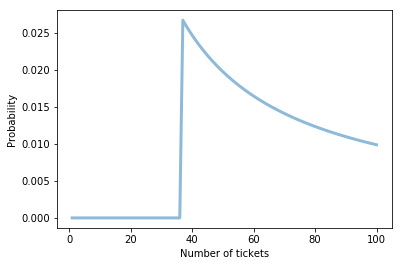

In [28]:
ts = TicketSuite(range(1, 101))
ts.bayesian_update(37)

xs, ys = ts.render()
plt.plot(xs, ys, linewidth=3, alpha=0.5)
    
plt.xlabel('Number of tickets')
plt.ylabel('Probability')
plt.show()

In [29]:
ts.weighted_average()

0.017224590018148234